In [109]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras import Sequential
from keras.layers import Input, Dense, Flatten, Reshape
from keras.models import Model
from math import sqrt

# Dataset

In [2]:
# Getting data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train_norm = x_train / 255.
x_test_norm = x_test / 255.

11490434/11490434 [==============================] - 0s 0us/step


# Constantes

In [3]:
LATENT_SIZE = 2
SHAPE = (28, 28)

# Construction du modèle AE / Fonctions de prédiction

In [10]:
# Building model / Prediction function

def auto_encoder(shape=SHAPE):

  encoder_layers = Sequential([
      Flatten(input_shape = shape),
      Dense(512, use_bias=True, activation="relu"),
      Dense(256, use_bias=True, activation="relu"),
      Dense(128, use_bias=True, activation="relu"),
      Dense(64, use_bias=True, activation="relu"),
      Dense(LATENT_SIZE, activation="relu"),
  ])

  decoder_layers = Sequential([
      Flatten(input_shape = (LATENT_SIZE,)),
      Dense(64, use_bias=True, activation="relu"),
      Dense(128, use_bias=True, activation="relu"),
      Dense(256, use_bias=True, activation="relu"),
      Dense(512, use_bias=True, activation="relu"),
      Dense(784, activation="sigmoid"),
      Reshape(shape)
  ])

  input = Input(shape=shape)
  latent_vector = encoder_layers(input)
  output = decoder_layers(latent_vector)
  return Model(inputs = input,  outputs = output), encoder_layers, decoder_layers


def AE_predict(model, X):
  X_norm = X / 255.
  predictions = model.predict(X_norm)
  predictions_norm =  predictions * 255.
  return predictions_norm

def E_predict(model, X):
  X_norm = X / 255.
  return model.predict(X_norm)

def D_predict(model, X):
  predictions = model.predict(X)
  predictions_norm =  predictions * 255.
  return predictions_norm

# Entrainement du modèle

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 sequential (Sequential)     (None, 2)                 574530    
                                                                 
 sequential_1 (Sequential)   (None, 28, 28)            575312    
                                                                 
Total params: 1,149,842
Trainable params: 1,149,842
Non-trainable params: 0
_________________________________________________________________
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 sequential (Sequential)     (None

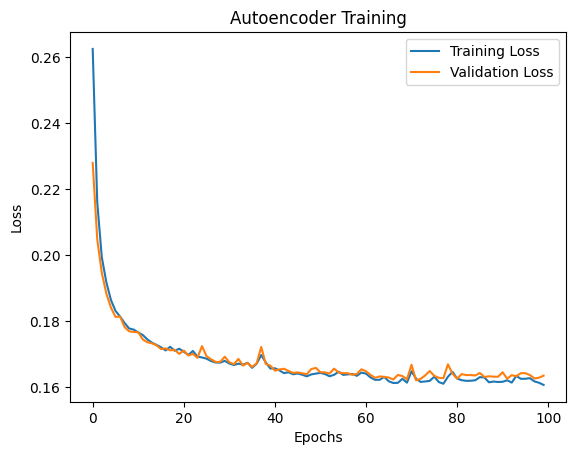

In [5]:
# AutoEncoder model
AE_model, encoder_layers, decoder_layers = auto_encoder()
AE_model.compile(tf.keras.optimizers.Adam(learning_rate=0.001), loss="binary_crossentropy", metrics=["mse"])
AE_model.summary()

# Encoder model
encoder_input = Input(shape=(28, 28))
encoder_output = encoder_layers(encoder_input)
E_model = Model(inputs = encoder_input, outputs = encoder_output)
E_model.summary()

# Decoder model
decoder_input = Input(shape=(LATENT_SIZE,))
decoder_output = decoder_layers(decoder_input)
D_model = Model(inputs = decoder_input, outputs = decoder_output)
D_model.summary()

# Fitting AE model
batch_size=10
history = AE_model.fit(
    x_train_norm,
    x_train_norm,
    epochs=100,
    validation_data=(
        x_test_norm, 
        x_test_norm
    ), 
    batch_size=300
)

# Retrieve the loss values from the training history
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the loss values
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Autoencoder Training')
plt.legend()
plt.show()

In [6]:
# Nombre de digits
N_DIGITS = 10
N_DIGITS_PER_CLASS = 10

# Compression / Decompression (AutoEncoder)

1/1 [==============================] - 0s 22ms/step


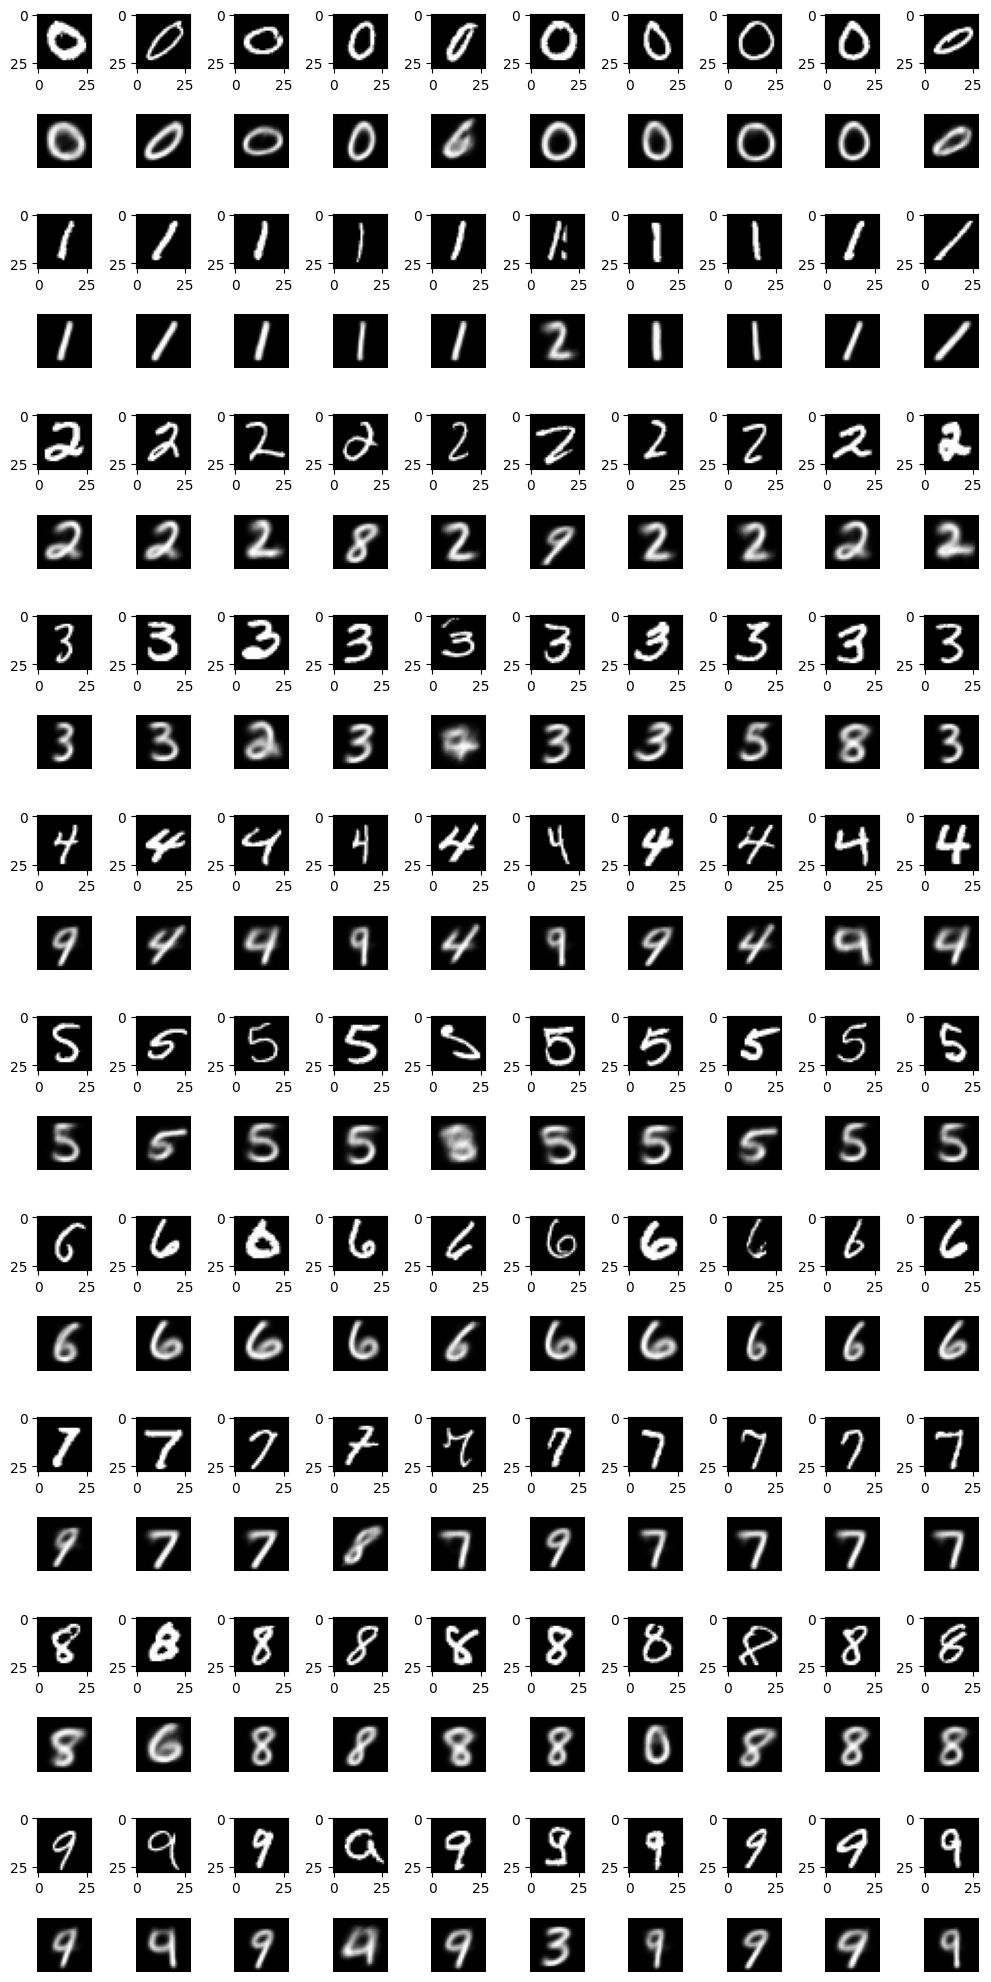

In [7]:
# AutoEncode images (Compression/Decompression)
fig, axs = plt.subplots(N_DIGITS * 2, N_DIGITS_PER_CLASS, figsize=(N_DIGITS_PER_CLASS, N_DIGITS * 2))

for n in range(N_DIGITS):
  digit_indexes = np.random.choice(np.where(y_test == n)[0], N_DIGITS_PER_CLASS)
  original_imgs = x_test[digit_indexes]
  predicted_imgs = AE_predict(AE_model, original_imgs)

  # Affichage des images originales
  for img_index in range(N_DIGITS_PER_CLASS):
    ax_original = axs[n * 2, img_index]
    ax_original.imshow(original_imgs[img_index].reshape(28, 28), cmap='gray')
    plt.gray()
    ax_predicted = axs[(n * 2) + 1, img_index]
    ax_predicted.imshow(predicted_imgs[img_index].reshape(28, 28), cmap='gray')
    plt.gray()
    ax_predicted.axis('off')

plt.tight_layout()
plt.gray()

# Reduction de dimension (Encoder 2D)

32/32 [==============================] - 0s 1ms/step


<ipython-input-11-1f8e51ee467c>:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  reductions = np.array(reductions)


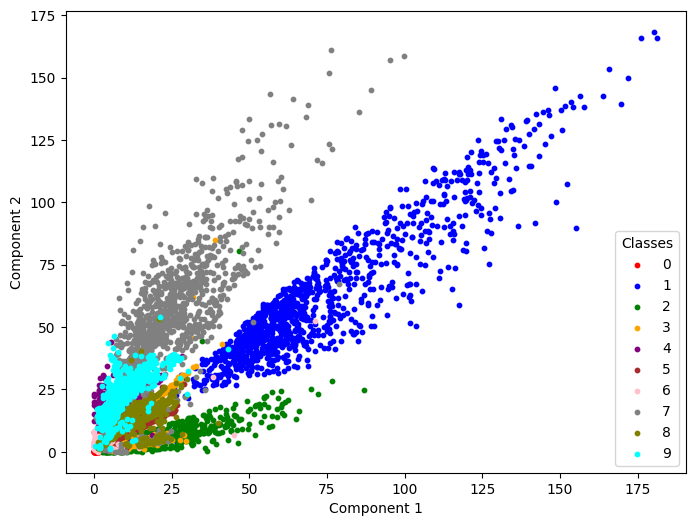

In [11]:
# Encode images (Reduction)
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
reductions = []

plt.figure(figsize=(8, 6))
for n in range(N_DIGITS):
    digit_indexes = np.where(y_test == n)[0]
    original_imgs = x_test[digit_indexes]
    predicted_imgs = E_predict(E_model, original_imgs)
    reductions.append(predicted_imgs)    
    plt.scatter(predicted_imgs[:, 0], predicted_imgs[:, 1], c=colors[n], label=str(n), s=10)
reductions = np.array(reductions)

plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(title="Classes")
plt.show()

# Generation (Decoder 2D -> 784D)

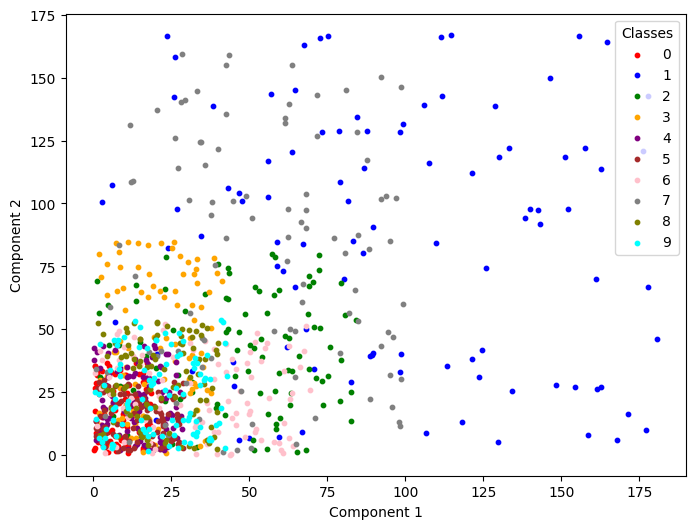

4/4 [==============================] - 0s 2ms/step


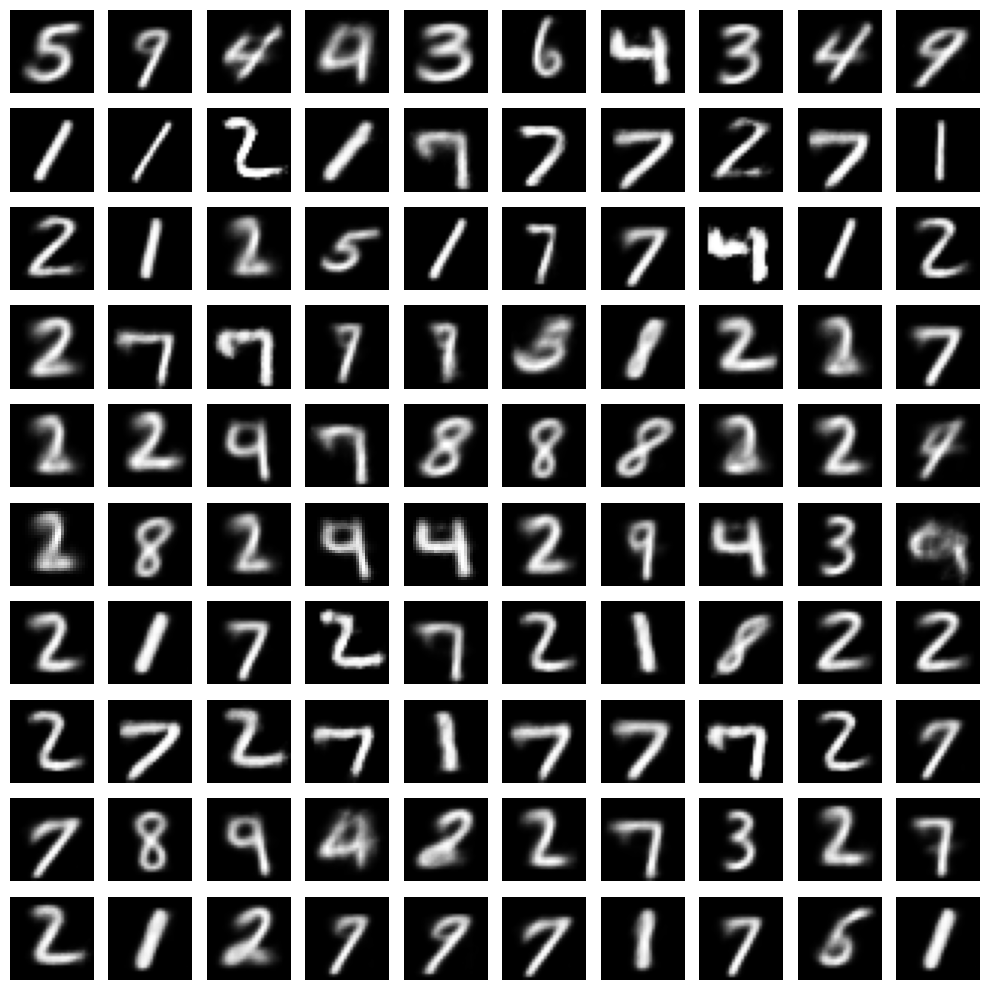

In [99]:
# Decode images [Generation]
GEN_N_SAMPLES_PER_CLASS = 100

# Calculer les limits des données projetées sur 2D
limits = []
for digit in reductions:
  limit = {
        'min0': digit[:,0].min(),
        'max0': digit[:,0].max(),
        'min1': digit[:,1].min(),
        'max1': digit[:,1].max()
    }
  limits.append(limit)
limits = np.array(limits)

# Choisir des échantillons pour chaque classe (entre le min et le max de la dictribution de chaque classe)
samples = []
for digit in range(N_DIGITS):
  sample_per_class = []
  for i in range(GEN_N_SAMPLES_PER_CLASS):
    sample_x = np.random.uniform(limits[digit]['min0'], limits[digit]['max0'])
    sample_y = np.random.uniform(limits[digit]['min1'], limits[digit]['max1'])
    sample_per_class.append(np.array([sample_x, sample_y]))
  samples.append(np.array(sample_per_class))
samples = np.array(samples)

# Afficher les échantillons choisis
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
plt.figure(figsize=(8, 6))
for n in range(N_DIGITS):
  plt.scatter(samples[n, :, 0], samples[n, :, 1], s=10,c=colors[n], label=str(n))
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(title="Classes")
plt.show()

# Generate images
GEN_N_SAMPLES_PER_CLASS_TO_SHOW = 10 # OVERWRITE
fig, axs = plt.subplots(N_DIGITS, GEN_N_SAMPLES_PER_CLASS_TO_SHOW, figsize=(GEN_N_SAMPLES_PER_CLASS_TO_SHOW, N_DIGITS))
for digit in range(N_DIGITS):
    predicted_imgs = D_predict(D_model, samples[digit])
    for sample in range(GEN_N_SAMPLES_PER_CLASS_TO_SHOW):
        ax = axs[digit, sample]
        ax.imshow(predicted_imgs[sample].reshape(28, 28), cmap='gray')
        ax.axis('off')
plt.tight_layout()
plt.gray()
plt.show()

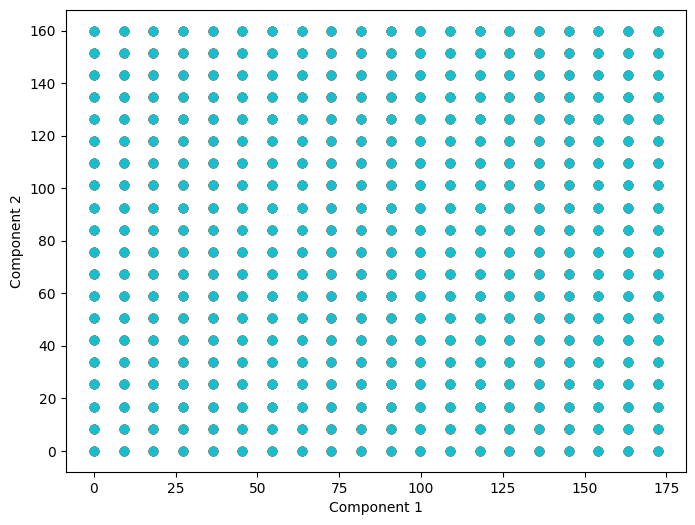

13/13 [==============================] - 0s 3ms/step
20


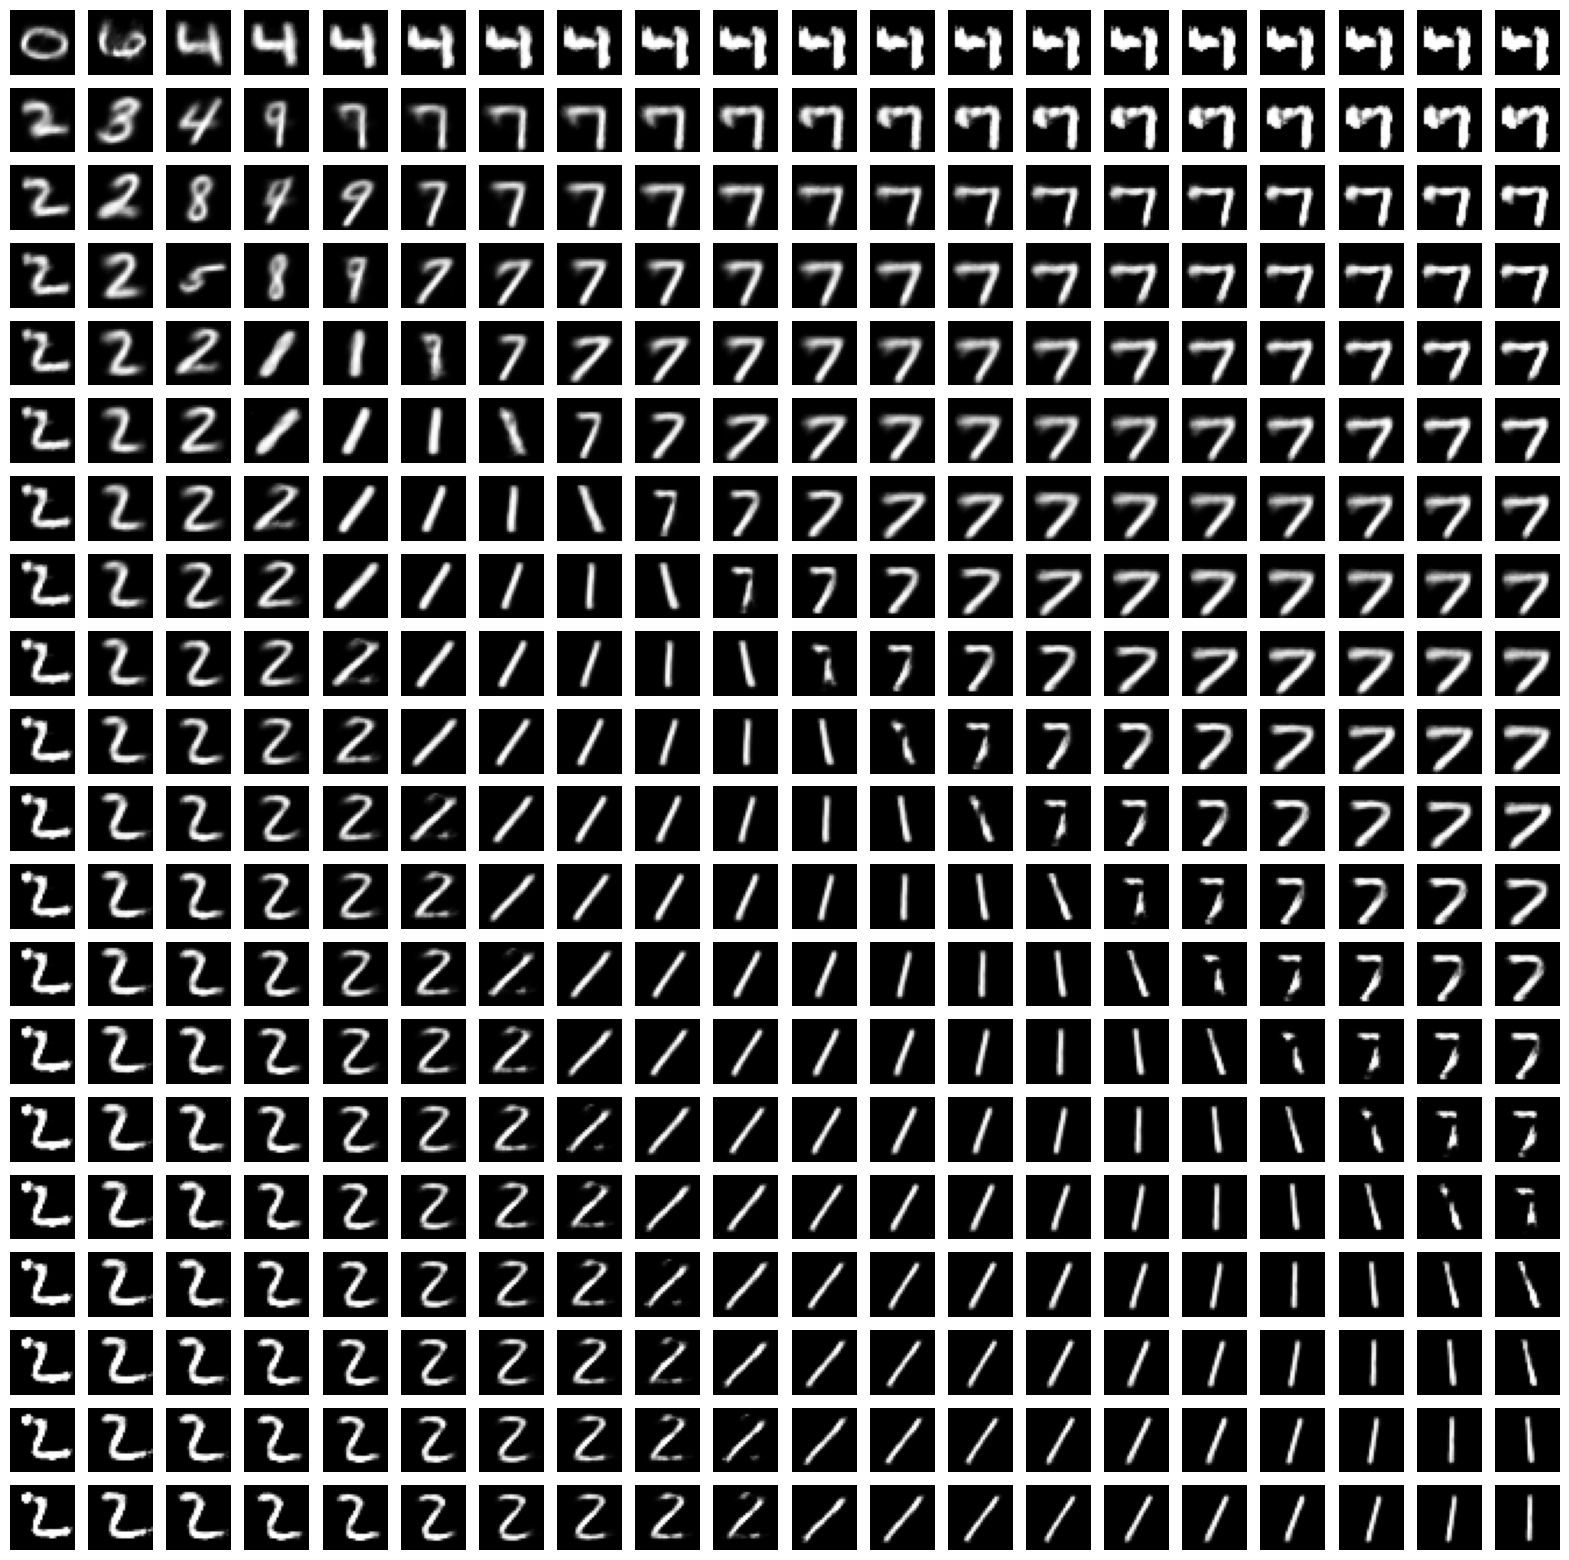

In [111]:
def plot_digits(X, n_samples):
    """
    Afficher les données digits en paramètre
    """
    h_w = int(sqrt(n_samples))
    print(h_w)
    fig, axs = plt.subplots(h_w, h_w, figsize=(h_w, h_w))
    for digit in range(h_w):
        for column in range(h_w):
            ax = axs[digit, column]
            ax.imshow(X[digit * h_w + column], cmap='gray')
            ax.axis('off')


axe0_min = min([limits[i]['min0'] for i in range(len(limits))])
axe0_max = max([limits[i]['max0'] for i in range(len(limits))])
axe1_min = min([limits[i]['min1'] for i in range(len(limits))])
axe1_max = max([limits[i]['max1'] for i in range(len(limits))])
GEN_N_SAMPLES_GLOBAL = 400

# Choisir des échantillons pour chaque classe (entre le min et le max de la dictribution de chaque classe)
samples = []
SQRT_GEN_N_SAMPLES_GLOBAL = int(sqrt(GEN_N_SAMPLES_GLOBAL))
for i in range(SQRT_GEN_N_SAMPLES_GLOBAL):
  sample_x = axe0_min + (axe0_max - axe0_min) * i / SQRT_GEN_N_SAMPLES_GLOBAL
  for j in range(SQRT_GEN_N_SAMPLES_GLOBAL):
    sample_y = axe1_min + (axe1_max - axe1_min) * j / SQRT_GEN_N_SAMPLES_GLOBAL
    samples.append(np.array([sample_x, sample_y]))
samples = np.array(samples)

# Afficher les échantillons choisis
plt.figure(figsize=(8, 6))
for n in range(SQRT_GEN_N_SAMPLES_GLOBAL):
  plt.scatter(samples[:, 0], samples[:, 1])
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()
predicted_imgs = D_predict(D_model, samples)
plot_digits(predicted_imgs, GEN_N_SAMPLES_GLOBAL)